# CVaR Portfolio Optimization with cuOpt Python API

This notebook demonstrates Conditional Value at Risk (CVaR) portfolio optimization using NVIDIA's cuOpt Python API with S&P 500 stock data.

## Overview

**Conditional Value at Risk (CVaR)** is a risk measure that quantifies the expected loss in the worst-case scenarios beyond a certain confidence level. It's particularly useful for portfolio optimization as it provides a coherent risk measure that captures tail risk.

### CVaR Formulation

The CVaR portfolio optimization problem can be formulated as:

$$
\begin{align}
\text{maximize: } & \mu^T w - \lambda \text{CVaR}_\alpha(w) \\
\text{subject to: } & \mathbf{1}^T w = 1 \\
& w_i^{\min} \leq w_i \leq w_i^{\max}, \quad i = 1, \ldots, n
\end{align}
$$

Where:
- $w$ is the portfolio weight vector
- $\mu$ is the expected return vector
- $\lambda$ is the risk aversion parameter
- $\text{CVaR}_\alpha(w)$ is the Conditional Value at Risk at confidence level $\alpha$

### Data Source
We use S&P 500 stock data from `./cuFOLIO_portfolio_optimization/data/stock_data/sp500.csv` which contains historical price data for S&P 500 constituents.

### Requirements
- **GPU**: NVIDIA GPU with CUDA support (recommended for optimal performance)
- **CUDA**: Version 12.x or 13.x
- **Python**: 3.10 or higher
- **Memory**: Sufficient RAM for large-scale optimization (8GB+ recommended)

### Installation Notes
- cuOpt requires an NVIDIA GPU and CUDA toolkit
- The package is available through NVIDIA's PyPI index
- Different versions are available for different CUDA versions (cu11, cu12)
- For CPU-only environments, consider using alternative optimization libraries


## 1. Environment Setup and Installation

### 1.1 Install Required Dependencies


In [1]:
# Check GPU availability
!nvidia-smi


Mon Oct  6 12:49:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro P620                    On  |   00000000:42:00.0 Off |                  N/A |
| 34%   41C    P8            N/A  /  N/A  |      10MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install cuOpt and other required packages
# Uncomment the following lines if running in a new environment

# For CUDA 12.x systems:
# !pip install --upgrade --extra-index-url https://pypi.nvidia.com --user cuopt-cu12

# For CUDA 13.x systems:
# !pip install --upgrade --extra-index-url https://pypi.nvidia.com --user cuopt-cu13

# Install other dependencies
!pip install numpy pandas matplotlib seaborn scipy

### 1.2 Import Required Libraries


In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# cuOpt imports
from cuopt.linear_programming.problem import Problem, VType, sense, LinearExpression
from cuopt.linear_programming.solver_settings import SolverSettings, PDLPSolverMode
from cuopt.linear_programming.solver.solver_parameters import *

# Set random seed for reproducibility
np.random.seed(42)

### 1.3 Configure Solver Settings


In [4]:
# Configure solver settings for larger problem
solver_settings = SolverSettings()
solver_settings.set_parameter("time_limit", 300.0)  # 5 minute time limit for larger problem
solver_settings.set_parameter("log_to_console", True)  # Enable solver logging
solver_settings.set_parameter("method", 0)  # Use default method


### 1.4 Load S&P 500 Data


In [5]:
# Load S&P 500 data
data_path = './cuFOLIO_portfolio_optimization/data/stock_data/sp500.csv'
df = pd.read_csv(data_path, index_col='Date', parse_dates=True)

print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Number of assets: {len(df.columns)}")
print(f"\nFirst few columns: {list(df.columns[:10])}")

# Display basic statistics
df.head()


Date range: 2005-01-03 00:00:00 to 2024-04-30 00:00:00
Number of assets: 397

First few columns: ['A', 'AAPL', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK']


,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WRB,WST,WTW,WY,WYNN,XEL,XOM,YUM,ZBH,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,14.464984,0.956809,14.226119,4.233333,18.853397,30.838949,22.999895,13.990722,22.002617,37.410706,...,6.728450,10.491922,70.318451,12.676677,35.713982,8.787888,26.210306,11.747929,69.549500,55.509998
2005-01-04,14.083369,0.966636,14.082849,4.177778,18.410120,30.024111,22.374182,13.837815,21.651375,34.981960,...,6.709743,10.574863,70.811386,12.481799,35.637714,8.656216,26.032394,11.592365,69.523186,54.470001
2005-01-05,14.077308,0.975101,13.921289,4.153333,18.338633,29.859142,22.475311,13.602094,21.561064,35.251820,...,6.693909,10.574863,69.689575,12.534776,36.040890,8.558681,25.896343,11.564758,68.979958,52.570000
2005-01-06,13.768386,0.975857,14.235263,4.147778,18.174191,29.364239,22.437397,13.882415,21.415545,35.081905,...,6.732767,10.562422,69.400627,12.585852,37.501038,8.544052,26.226011,11.695234,69.777283,52.650002
2005-01-07,13.756269,1.046911,14.479119,4.191111,19.024984,29.384233,22.468996,13.914271,21.375414,34.282318,...,6.691029,10.533389,68.516754,12.782634,36.253368,8.495282,26.053328,11.630003,69.654602,53.099998


## 2. Data Preprocessing and Return Calculation


In [6]:
# Use all S&P 500 assets with complete data
# Remove any assets with missing data
price_data = df.dropna(axis=1, how='any')  # Drop columns with any NaN values
selected_assets = price_data.columns

print(f"Total assets in dataset: {len(df.columns)}")
print(f"Assets with complete data: {len(selected_assets)}")
print(f"Price data shape: {price_data.shape}")
print(f"Selected assets (first 10): {list(selected_assets[:10])}")

# Calculate log returns
returns = np.log(price_data / price_data.shift(1)).dropna()

print(f"Returns data shape: {returns.shape}")
print(f"Returns date range: {returns.index.min()} to {returns.index.max()}")

# Display return statistics
print("\nReturn Statistics (first 5 assets):")
print(returns.iloc[:, :5].describe())


Total assets in dataset: 397
Assets with complete data: 397
Price data shape: (4864, 397)
Selected assets (first 10): ['A', 'AAPL', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK']
Returns data shape: (4863, 397)
Returns date range: 2005-01-04 00:00:00 to 2024-04-30 00:00:00

Return Statistics (first 5 assets):
                 A         AAPL          ABT         ACGL          ACN
count  4863.000000  4863.000000  4863.000000  4863.000000  4863.000000
mean      0.000462     0.001066     0.000413     0.000637     0.000570
std       0.019274     0.020429     0.013795     0.015633     0.016319
min      -0.116690    -0.197470    -0.102982    -0.184827    -0.144498
25%      -0.008411    -0.008457    -0.006327    -0.006095    -0.007144
50%       0.000895     0.000990     0.000430     0.000918     0.000954
75%       0.010221     0.011700     0.007655     0.007772     0.008602
max       0.138395     0.130194     0.103783     0.142868     0.151577


In [7]:
# Calculate expected returns and covariance matrix
mu = returns.mean().values  # Expected returns
Sigma = returns.cov().values  # Covariance matrix
n_assets = len(selected_assets)

# Annualize returns (assuming 252 trading days)
mu_annual = mu * 252
Sigma_annual = Sigma * 252

print(f"\nAnnualized expected returns (top 5):")
for i in range(5):
    print(f"{selected_assets[i]}: {mu_annual[i]:.4f}")



Annualized expected returns (top 5):
A: 0.1165
AAPL: 0.2685
ABT: 0.1041
ACGL: 0.1604
ACN: 0.1435


## 3. CVaR Scenario Generation

For CVaR optimization, we need to generate scenarios of portfolio returns. We'll use historical simulation and Monte Carlo methods.


In [8]:
# Historical simulation scenarios
historical_scenarios = returns.values
n_scenarios_hist = historical_scenarios.shape[0]

print(f"Historical scenarios: {n_scenarios_hist}")
print(f"Number of assets: {len(selected_assets)}")

# For computational efficiency with many assets, use fewer Monte Carlo scenarios
# Adjust based on problem size
n_scenarios_mc = min(2000, n_scenarios_hist)  # Use at most 2000 MC scenarios
mc_scenarios = np.random.multivariate_normal(mu, Sigma, n_scenarios_mc)

print(f"Monte Carlo scenarios: {n_scenarios_mc}")

# Combine scenarios
all_scenarios = np.vstack([historical_scenarios, mc_scenarios])
n_scenarios_total = all_scenarios.shape[0]
scenario_probs = np.ones(n_scenarios_total) / n_scenarios_total

print(f"Total scenarios: {n_scenarios_total}")
print(f"Scenario matrix shape: {all_scenarios.shape}")
print(f"Problem size: {len(selected_assets)} assets × {n_scenarios_total} scenarios = {len(selected_assets) * n_scenarios_total} scenario-asset combinations")


Historical scenarios: 4863
Number of assets: 397
Monte Carlo scenarios: 2000
Total scenarios: 6863
Scenario matrix shape: (6863, 397)
Problem size: 397 assets × 6863 scenarios = 2724611 scenario-asset combinations


## 4. CVaR Portfolio Optimization with cuOpt

Now we'll implement the CVaR optimization using cuOpt's linear programming interface. The CVaR optimization problem can be reformulated as a linear program.


In [9]:
def solve_cvar_portfolio(scenarios, scenario_probs, mu, alpha=0.95, lambda_risk=1.0, 
                        w_min=None, w_max=None, solver_settings=None):
    """
    Solve CVaR portfolio optimization using cuOpt linear programming.
    
    Parameters:
    - scenarios: numpy array of return scenarios (n_scenarios x n_assets)
    - scenario_probs: probability weights for scenarios
    - mu: expected returns vector
    - alpha: confidence level for CVaR (default 0.95)
    - lambda_risk: risk aversion parameter (default 1.0)
    - w_min, w_max: bounds on portfolio weights
    - solver_settings: cuOpt solver settings
    
    Returns:
    - optimal_weights: optimal portfolio weights
    - cvar_value: CVaR value at optimum
    - expected_return: expected portfolio return
    """
    
    n_scenarios, n_assets = scenarios.shape
    
    if w_min is None:
        w_min = np.zeros(n_assets)
    if w_max is None:
        w_max = np.ones(n_assets)
    
    # Create the linear programming problem
    problem = Problem("cvar_portfolio_optimization")
    
    # Decision variables
    # Portfolio weights
    w = {}
    for i in range(n_assets):
        w[i] = problem.addVariable(name=f"w_{i}", vtype=VType.CONTINUOUS, 
                                  lb=w_min[i], ub=w_max[i])
    
    # CVaR auxiliary variables
    t = problem.addVariable(name="t", vtype=VType.CONTINUOUS, 
                           lb=-float('inf'), ub=float('inf'))  # VaR variable
    u = {}
    for s in range(n_scenarios):
        u[s] = problem.addVariable(name=f"u_{s}", vtype=VType.CONTINUOUS, 
                                  lb=0.0, ub=float('inf'))  # CVaR auxiliary
    
    # Objective: maximize expected return - lambda * CVaR
    # CVaR = t + (1/(1-alpha)) * sum(p_s * u_s)
    objective_expr = LinearExpression([], [], 0.0)
    
    # Add expected return terms
    for i in range(n_assets):
        if mu[i] != 0:
            objective_expr += w[i] * mu[i]
    
    # Subtract CVaR terms to penalize higher risk (lower CVaR increases objective value)
    if lambda_risk != 0:
        objective_expr -= t * lambda_risk
        cvar_coeff = lambda_risk / (1.0 - alpha)
        for s in range(n_scenarios):
            if scenario_probs[s] != 0:
                objective_expr -= u[s] * (cvar_coeff * scenario_probs[s])
    
    problem.setObjective(objective_expr, sense.MAXIMIZE)
    
    # Constraints
    # Budget constraint: sum of weights = 1
    budget_expr = LinearExpression([], [], 0.0)
    for i in range(n_assets):
        budget_expr += w[i]
    problem.addConstraint(budget_expr == 1.0, name="budget")
    
    # CVaR constraints: u_s >= -R_s^T * w - t for all scenarios s
    for s in range(n_scenarios):
        cvar_constraint_expr = LinearExpression([], [], 0.0)
        cvar_constraint_expr += u[s]  # u_s
        cvar_constraint_expr += t     # + t
        
        # Add portfolio return terms: + R_s^T * w
        for i in range(n_assets):
            if scenarios[s, i] != 0:
                cvar_constraint_expr += w[i] * scenarios[s, i]
        
        problem.addConstraint(cvar_constraint_expr >= 0.0, name=f"cvar_{s}")
    
    # Solve the optimization problem
    if solver_settings is not None:
        problem.solve(solver_settings)
    else:
        problem.solve()
    
    if problem.Status.name == "Optimal":
        # Extract optimal solution
        optimal_weights = np.array([w[i].getValue() for i in range(n_assets)])
        t_value = t.getValue()
        u_values = np.array([u[s].getValue() for s in range(n_scenarios)])
        
        # Calculate CVaR and expected return
        cvar_value = t_value + (1.0 / (1.0 - alpha)) * np.sum(scenario_probs * u_values)
        expected_return = np.dot(mu, optimal_weights)
        
        return optimal_weights, cvar_value, expected_return, problem
    else:
        raise RuntimeError(f"Optimization failed with status: {problem.Status.name}")

## 5. Solve the CVaR Optimization Problem


In [10]:
# Set optimization parameters
alpha = 0.95  # 95% confidence level
lambda_risk = 2.0  # Risk aversion parameter

# Portfolio weight bounds for DIVERSIFIED portfolio
w_min = np.zeros(n_assets)  # No short selling
w_max = np.ones(n_assets) # Maximum can be 100% in any single asset

print(f"Diversification constraints:")
print(f"- Maximum weight per asset: {w_max[0]:.1%}")
print(f"- This forces allocation across at least {1/w_max[0]:.0f} assets")

# Alternative diversification strategies (uncomment to try):

# Strategy 1: Even more diversified (max 10% per asset)
# w_max = np.ones(n_assets) * 0.10

# Strategy 2: Minimum holdings requirement (forces broader diversification)
# min_holdings = 30  # Require at least 30 assets
# w_min = np.zeros(n_assets)
# w_min[:min_holdings] = 0.005  # Minimum 0.5% in top assets

# Strategy 3: Lower risk aversion (allows more return-seeking behavior)
# lambda_risk = 0.5  # Less conservative approach

print(f"- Confidence level (alpha): {alpha}")
print(f"- Risk aversion (lambda): {lambda_risk}")
print(f"- Number of scenarios: {n_scenarios_total}")
print(f"- Number of assets: {n_assets}")

# Solve the optimization problem
try:
    optimal_weights, cvar_value, expected_return, solve_result = solve_cvar_portfolio(
        scenarios=all_scenarios,
        scenario_probs=scenario_probs,
        mu=mu_annual,  # Use annualized returns
        alpha=alpha,
        lambda_risk=lambda_risk,
        w_min=w_min,
        w_max=w_max,
        solver_settings=solver_settings
    )
    
    print(f"\nOptimization successfuli!")
    print(f"Status: {solve_result.Status.name}")
    print(f"Objective value: {solve_result.ObjValue:.6f}")
    print(f"Expected annual return: {expected_return:.4f} ({expected_return*100:.2f}%)")
    print(f"CVaR (95%): {cvar_value:.4f}")
    
except Exception as e:
    print(f"Optimization failed: {e}")


Diversification constraints:
- Maximum weight per asset: 100.0%
- This forces allocation across at least 1 assets
- Confidence level (alpha): 0.95
- Risk aversion (lambda): 2.0
- Number of scenarios: 6863
- Number of assets: 397
Setting parameter time_limit to 3.000000e+02
Setting parameter log_to_console to true
Setting parameter method to 0
cuOpt version: 25.10.0, git hash: f4082fe3, host arch: x86_64, device archs: 75
CPU: AMD Ryzen Threadripper PRO 3975WX 32-Cores, threads (physical/logical): 32/64, RAM: 1.65 GiB
CUDA 13.0, device: Quadro RTX 8000 (ID 0), VRAM: 47.25 GiB
CUDA device UUID: ffffffb7fffffff2ffffffb679-057e-ffff

Third-party presolve is disabled, skipping
Solving a problem with 6864 constraints 7261 variables (0 integers) and 2725089 nonzeros
Objective offset -0.000000 scaling_factor -1.000000
Running concurrent

   Iter    Primal Obj.      Dual Obj.    Gap        Primal Res.  Dual Res.   Time
      0 -0.00000000e+00 -0.00000000e+00  0.00e+00   1.00e+00     3.08e+00   

## 6. Analyze the Optimal Portfolio


In [11]:
# Create portfolio results DataFrame
portfolio_df = pd.DataFrame({
    'Asset': selected_assets,
    'Weight': optimal_weights,
    'Expected_Return': mu_annual
})

# Sort by weight (descending)
portfolio_df = portfolio_df.sort_values('Weight', ascending=False)

# Display portfolio composition (top holdings only)
significant_holdings = portfolio_df[portfolio_df['Weight'] > 0.001]  # Only assets with weight > 0.1%
top_holdings = significant_holdings.head(20)  # Show top 20 holdings

print("Optimal Portfolio Composition (Top 20 Holdings):")
print("=" * 70)
for _, row in top_holdings.iterrows():
    print(f"{row['Asset']:>6}: {row['Weight']:>8.4f} ({row['Weight']*100:>6.2f}%) | Expected Return: {row['Expected_Return']:>8.4f}")

Optimal Portfolio Composition (Top 20 Holdings):
  NVDA:   0.3300 ( 33.00%) | Expected Return:   0.3199
  AAPL:   0.3208 ( 32.08%) | Expected Return:   0.2685
  NFLX:   0.2485 ( 24.85%) | Expected Return:   0.2995
  MNST:   0.0689 (  6.89%) | Expected Return:   0.2560
  BKNG:   0.0320 (  3.20%) | Expected Return:   0.2582


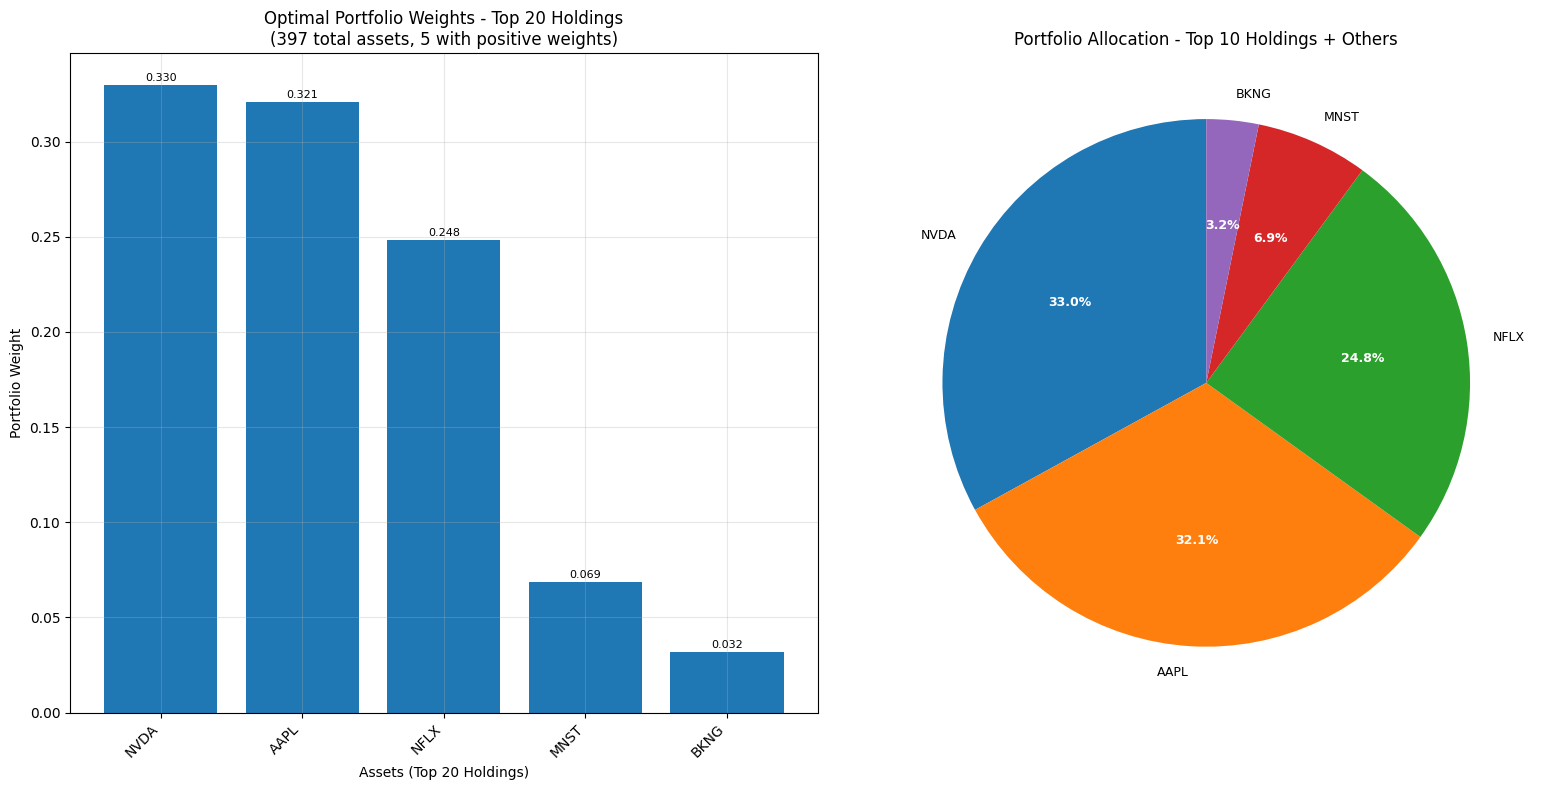


Concentration Analysis:
Herfindahl-Hirschman Index (HHI): 0.279259
Effective number of assets: 3.58
Diversification ratio: 5/397 = 1.26%


In [12]:
# Visualize portfolio composition
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Portfolio weights bar chart (top 20 holdings)
top_20_holdings = significant_holdings.head(20)
bars = ax1.bar(range(len(top_20_holdings)), top_20_holdings['Weight'])
ax1.set_xlabel('Assets (Top 20 Holdings)')
ax1.set_ylabel('Portfolio Weight')
ax1.set_title(f'Optimal Portfolio Weights - Top 20 Holdings\n({len(selected_assets)} total assets, {len(significant_holdings)} with positive weights)')
ax1.set_xticks(range(len(top_20_holdings)))
ax1.set_xticklabels(top_20_holdings['Asset'], rotation=45, ha='right')
ax1.grid(True, alpha=0.3)

# Add value labels on bars for top holdings
for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0.01:  # Only label if weight > 1%
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Portfolio weights pie chart (top 10 holdings)
top_10_holdings = significant_holdings.head(10)
other_weight = significant_holdings.iloc[10:]['Weight'].sum() if len(significant_holdings) > 10 else 0

if other_weight > 0:
    pie_data = list(top_10_holdings['Weight']) + [other_weight]
    pie_labels = list(top_10_holdings['Asset']) + [f'Others ({len(significant_holdings)-10} assets)']
else:
    pie_data = top_10_holdings['Weight']
    pie_labels = top_10_holdings['Asset']

wedges, texts, autotexts = ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', 
                                  startangle=90, textprops={'fontsize': 9})
ax2.set_title('Portfolio Allocation - Top 10 Holdings + Others')

# Improve pie chart readability
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

# Additional statistics
print(f"\nConcentration Analysis:")
print(f"Herfindahl-Hirschman Index (HHI): {np.sum(optimal_weights**2):.6f}")
print(f"Effective number of assets: {1/np.sum(optimal_weights**2):.2f}")
print(f"Diversification ratio: {len(significant_holdings)}/{len(selected_assets)} = {len(significant_holdings)/len(selected_assets):.2%}")


In [13]:
# Final summary statistics
print("CVaR Portfolio Optimization Summary")
print("=" * 50)
print(f"Dataset: S&P 500 stocks ({n_assets} assets)")
print(f"Optimization method: CVaR with cuOpt GPU acceleration")
print(f"Confidence level: {alpha*100}%")
print(f"Risk aversion parameter: {lambda_risk}")
print(f"Number of scenarios: {n_scenarios_total:,}")

if 'optimal_weights' in locals():
    portfolio_std = np.std(all_scenarios @ optimal_weights) * np.sqrt(252)
    print(f"\nOptimal Portfolio Performance:")
    print(f"- Expected annual return: {expected_return:.2%}")
    print(f"- Annual volatility: {portfolio_std:.2%}")
    print(f"- Sharpe ratio: {expected_return/portfolio_std:.3f}")
    print(f"- CVaR (95%): {cvar_value:.2%}")
    print(f"- Number of assets with positive weights: {np.sum(optimal_weights > 0.001)}")
    
    # Top 5 holdings
    top_5 = portfolio_df.head(5)
    print(f"\nTop 5 Holdings:")
    for _, row in top_5.iterrows():
        if row['Weight'] > 0.001:
            print(f"- {row['Asset']}: {row['Weight']:.2%}")
    
    print(f"\nComputational Performance:")
    print(f"- Solver status: {solve_result.Status.name}")
    print(f"- Objective value: {solve_result.ObjValue:.6f}")
else:
    print("\nOptimization was not successful - please check the previous cells.")


CVaR Portfolio Optimization Summary
Dataset: S&P 500 stocks (397 assets)
Optimization method: CVaR with cuOpt GPU acceleration
Confidence level: 95.0%
Risk aversion parameter: 2.0
Number of scenarios: 6,863

Optimal Portfolio Performance:
- Expected annual return: 29.20%
- Annual volatility: 31.52%
- Sharpe ratio: 0.926
- CVaR (95%): 4.50%
- Number of assets with positive weights: 5

Top 5 Holdings:
- NVDA: 33.00%
- AAPL: 32.08%
- NFLX: 24.85%
- MNST: 6.89%
- BKNG: 3.20%

Computational Performance:
- Solver status: Optimal
- Objective value: 0.201904


## 8. Summary and Key Takeaways

This notebook demonstrated how to implement CVaR portfolio optimization using NVIDIA's cuOpt Python API with S&P 500 data. 

### Key Features Implemented:
1. **GPU-Accelerated Optimization**: Used cuOpt for fast linear programming solution
2. **CVaR Risk Management**: Implemented conditional value-at-risk as the risk measure
3. **Scenario-Based Approach**: Combined historical and Monte Carlo simulation scenarios
4. **Diversification Constraints**: Added maximum weight limits to improve portfolio diversification
5. **Comprehensive Analysis**: Portfolio composition, risk metrics, and visualization

### Diversification Strategies Available:
- **Maximum Weight Constraints**: Limit concentration in any single asset
- **Minimum Weight Requirements**: Force broader asset allocation across more assets
- **Risk Aversion Adjustment**: Lower lambda_risk for more return-seeking behavior

---
SPDX-FileCopyrightText: Copyright (c) 2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved.

SPDX-License-Identifier: MIT
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
